# Ordinary Differential Equations

![](2022-01-19-15-18-00.png)

In [268]:
import numpy as np
import jax.numpy as jnp
%matplotlib inline
import matplotlib.pyplot as plt

## Dynamics of ideal pendulum

We want to predict how the angle of a pendulum, $u$ changes as a function of time subject to gravity.
The dynamical system can be characterized by two states: 
* $\theta$ : the angle
* $\omega$ : the angular velocity

Note that the states of a system do not have to be derivatives of each other, it just happens to be the case for many dynamical systems describing physical phenomena.

![](2022-01-19-15-19-07.png)

### Phase portrait

![](2022-01-19-15-21-13.png)

(-1.0, 1.0)

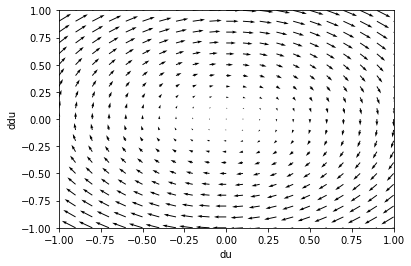

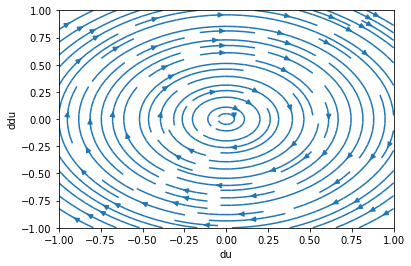

In [269]:
m = 1.0 # mass
g = 1.0 # gravity

x_min = -1.0
x_max = 1.0
y_min = -1.0
y_max = 1.0
dx = 0.1
dy = 0.1

def f(u, du):
    ddu = -(g/m)*jnp.sin(u)
    return du, ddu

x, y = np.meshgrid(np.arange(x_min,x_max+dx,dx), np.arange(y_min, y_max+dy,dy))
du,ddu = f(x,y)

fig, ax = plt.subplots()
plt.quiver(x,y,du,ddu, scale_units="xy",angles="xy")
plt.xlabel("du")
plt.ylabel("ddu")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)


fig, ax = plt.subplots()
plt.streamplot(x,y,du,ddu)
plt.xlabel("du")
plt.ylabel("ddu")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)


## Obtaining a trajectory
![](2022-01-19-15-22-51.png)

### Implementing Forward Euler

(-1.0, 1.0)

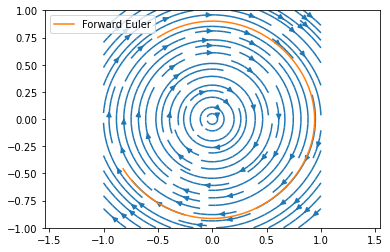

In [270]:
t_start = 0.0
t_end = 5.0
dt = 0.01
t_eval = np.arange(t_start, t_end+dt ,dt)
y0 = (-0.5, 0.75)

def solve_forward_euler(t_start, t_end, dt, y0):
    y0 = np.array(y0)
    t_eval = t_eval = np.arange(t_start, t_end+dt ,dt)
    y = y0
    ys = [y0]
    for t in t_eval[:-1]:
        dy = np.array(f(*y))
        y = y + dt*dy
        ys.append(y)
    
    return np.stack(ys,axis=1)

u_fe, du_fe = solve_forward_euler(t_start,t_end,dt,y0)
fig, ax = plt.subplots()
ax.streamplot(x,y,du,ddu)
ax.plot(u_fe,du_fe, label="Forward Euler")
ax.axis("equal")
ax.legend()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

### Using third-party solver

(-1.0, 1.0)

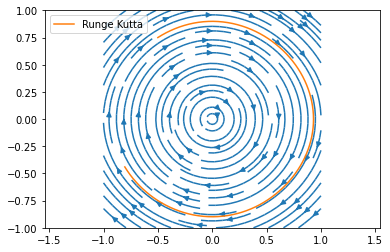

In [271]:
from scipy.integrate import solve_ivp

u_rk45, du_rk45 = solve_ivp(lambda _, y : f(*y), (t_start,t_end), y0, "RK45", t_eval).y

fig, ax = plt.subplots()
ax.streamplot(x,y,du,ddu)
ax.plot(u_rk45,du_rk45, label="Runge Kutta")
ax.axis("equal")
ax.legend()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

## Learning dynamics from data
![](2022-01-19-15-24-47.png)

In [272]:
from jax.experimental.stax import serial, Dense, Softplus
from jax import random
from jax import vmap
import jax.numpy as jnp
from tqdm import tqdm

key = random.PRNGKey(0) # every random operation in jax is seeded

## Partially known dynamics
Suppose we know the shape of the derivative function, but only have rough estimates of the coefficients?

(-1.0, 1.0)

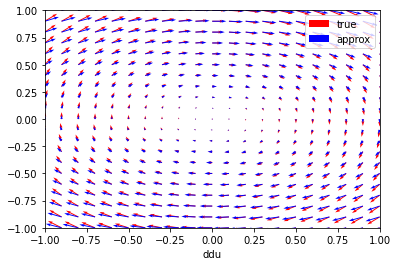

In [273]:
m_true = 1.0
m_approx = 2.0
g = 1.0

def f(u, du, m):
    ddu = - g/m * jnp.sin(u)
    return du, ddu

x, y = np.meshgrid(np.arange(x_min,x_max+dx,dx), np.arange(y_min, y_max+dy,dy))
du_approx, ddu_approx = f(x, y, m_approx)
du_true, ddu_true = f(x, y, m_true)

fig, ax = plt.subplots()
ax.quiver(x,y,du_true,ddu_true, scale_units="xy",angles="xy", label="true", color="red")
ax.quiver(x,y,du_approx,ddu_approx, scale_units="xy",angles="xy", label="approx", color="blue")
ax.legend()
ax.set_xlabel("du")
ax.set_xlabel("ddu")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

Is it possible to tune optimize the choice of $\hat{m}$ such that the dynamics of the true system are approximated well?

Two scenarios are:
1. We know ground truth derivatives, $du, ddu$
2. We know ground solutions trajectories $du(t), ddu(t)$ and use these to infer $du, ddu$ that lead to correct trajectories

In both cases we:
1. Define a loss function that measures the error in predictions for the models parameters, $\theta$
2. Obtain sensitivity of loss on models parameters $\frac{dL}{d\theta}(\theta)$
3. Update parameters to minimize loss

We use [JAX](https://jax.readthedocs.io/en/latest/) to implement the optimization loop.

### Minimize Error based on true derivatives

training: 100%|██████████| 60/60 [00:00<00:00, 177.74it/s]


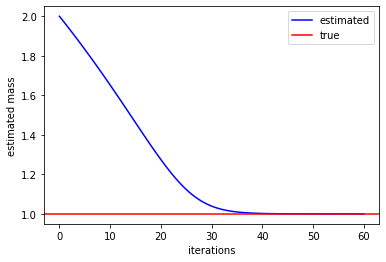

In [274]:
from jax import value_and_grad
from jax import jit

m_approx = 2.0
learning_rate = 0.001

def loss(m):
    du, ddu = f(x,y,m)
    return jnp.sum((du-du_true)**2 + (ddu-ddu_true)**2)

#@jit
def update(m):
    value, grad = value_and_grad(loss, argnums=0)(m)
    m = m - learning_rate * grad
    return m


ms = [m_approx]
for i in tqdm(range(60),desc="training"):
    
    m_approx = update(m_approx)
    ms.append(m_approx)

fig, ax = plt.subplots()
ax.plot(ms,label="estimated",c="blue")
ax.set_xlabel("iterations")
ax.set_ylabel("estimated mass")
ax.axhline(m_true,label="true",c="red")
ax.legend()

value of m estimated to 1.0000056028366089, true value is 1.0


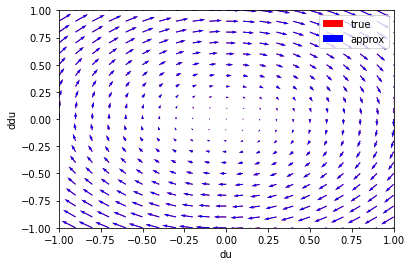

In [275]:
du_approx, ddu_approx = f(x, y, m_approx)
du_true, ddu_true = f(x, y, m_true)

fig, ax = plt.subplots()
ax.quiver(x,y,du_true,ddu_true, scale_units="xy",angles="xy", label="true", color="red")
ax.quiver(x,y,du_approx,ddu_approx, scale_units="xy",angles="xy", label="approx", color="blue")
ax.legend()
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_xlabel("du")
ax.set_ylabel("ddu")

print(f"value of m estimated to {m_approx}, true value is {m_true}")

### Minimize error based on solution
Alternatively, if we only have the solutions for dynamical system, we can use those to infer the parameters of the dynamics that result in the solution we have observed.
The process for tuning based on this is:
1. take an initial guess on m
2. simulate the system for initial conditions corresponding to those of the ground truth
3. calculate the difference between the solution produced by the approximate m and the ground truth
4. update m such that the difference is minimized
5. repeat 2-4

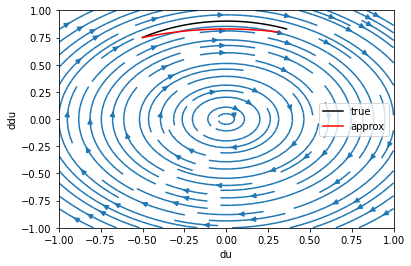

In [276]:
m_approx = 2.0
dt = 0.01
t_eval = jnp.arange(0.0, 1.0+dt, dt)


def simulate(u,du,m):
    
    U = [u]
    dU = [du]

    for _ in t_eval[:-1]:
        du, ddu = f(u,du,m)
        u = u + dt*du
        du = du + dt*ddu
        U.append(u)
        dU.append(du)

    return U, dU

u_true, du_true = simulate(*y0,m_true)
u_approx, du_approx = simulate(*y0,m_approx)
du, ddu = f(x, y, m_true)

fig, ax = plt.subplots()
ax.streamplot(x,y,du,ddu)
ax.set_xlabel("du")
ax.set_ylabel("ddu")
ax.plot(u_true,du_true,label="true",color="black")
ax.plot(u_approx,du_approx,label="approx",color="red")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.legend()

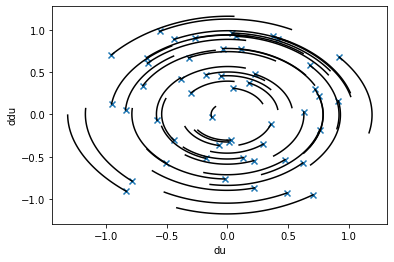

In [277]:
# initial conditions
x0, y0 = (random.uniform(key, (50, 2))*jnp.asarray((x_max-x_min, y_max-y_min)) + jnp.asarray((x_min, y_min))).T

# simulate and stack results for ease of plotting
U_true, dU_true = simulate(x0,y0,m_true)
U_true = jnp.stack(U_true,axis=1)
dU_true = jnp.stack(dU_true,axis=1)

fig, ax = plt.subplots()
ax.scatter(x0, y0, marker="x")
ax.set_xlabel("du")
ax.set_ylabel("ddu")
ax.plot(U_true.T, dU_true.T, color="black");

training: 100%|██████████| 1000/1000 [00:00<00:00, 5858.00it/s]


value of m estimated to be 1.0000027418136597


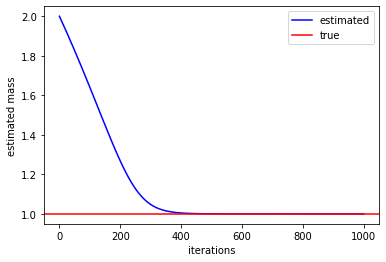

In [278]:
m_approx = 2.0
learning_rate = 0.001
y0 = jnp.array((0.5,0.5))
t_start = 0.0
t_end = 1.0
dt = 0.01
t_eval = jnp.arange(t_start,t_end+dt,dt)

def f(y,m):
    u,du = y
    ddu = -(g/m)*jnp.sin(u)
    return jnp.asarray((du, ddu))
    
def simulate(y0, t_eval, m):
    
    def h(y, slice):
        
        dy = f(y,m)
        y = y + dt*dy
        return y,y

    _, y = scan(h,y0, None, t_eval.shape[0])

    return y

y_true = simulate(y0,t_eval,m_true)

@jit
def update(m):
    def loss(m):        
        y = simulate(y0,t_eval,m)
        return jnp.sum((y_true - y)**2)

    value, grad = value_and_grad(loss, argnums=0)(m)
    m = m - learning_rate * grad
    return m

ms = [m_approx]
for i in tqdm(range(1000),desc="training"):
    
    m_approx = update(m_approx)
    ms.append(m_approx)

fig, ax = plt.subplots()
ax.plot(ms,label="estimated",c="blue")
ax.set_xlabel("iterations")
ax.set_ylabel("estimated mass")
ax.axhline(m_true,label="true",c="red")
ax.legend()

print(f"value of m estimated to be {m_approx}")

## Completely unknown dynamics

In cases where the dynamics are totally unknown we can replace the explicitly defined derivative function with a *feed-forward neural network*.

### Constructing the network

In [279]:
init_net, net = serial(Dense(32),Softplus, Dense(2))

_, params = init_net(key,(2,))

net(params, jnp.ones((2,)))

DeviceArray([-0.31260395, -1.5107025 ], dtype=float32)

### Forward pass

In [280]:
def simulate_net(params, y0, t_eval):
    
    def h(y, slice):
        
        dy = net(params,y) # only difference
        y = y + dt*dy
        return y,y

    _, y = scan(h,y0, None, t_eval.shape[0])

    return y

### Optimization loop
the parameters of a NN are represented as a tree structure unlike before when the only parameters was scalar.

To faclitate the update of the coefificents we use an optimizer from jax.experimental.optimizers

training: 100%|██████████| 100000/100000 [00:04<00:00, 20416.38it/s]


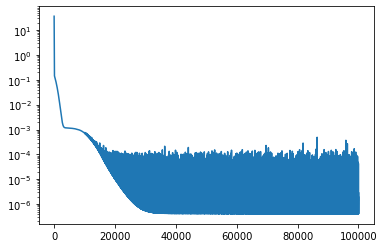

In [281]:
from jax.experimental.optimizers import adam

init_fun, update_fun, get_params = adam(learning_rate)
opt_state = init_fun(params)

losses = []

@jit
def update(opt_state):
    
    def loss(params):        
        y = simulate_net(params,y0,t_eval)
        return jnp.sum((y_true - y)**2)

    value, grads = value_and_grad(loss, argnums=0)(get_params(opt_state))
    opt_state = update_fun(0,grads,opt_state)    
    return value, opt_state

for i in tqdm(range(100000),desc="training"):
    value, opt_state = update(opt_state)
    losses.append(value)

params = get_params(opt_state)

fig,ax = plt.subplots()
ax.plot(losses)
ax.set_yscale("log")


### Validation

(-1.0, 1.0)

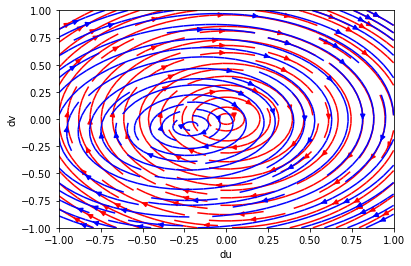

In [283]:
x,y = np.meshgrid(np.arange(x_min,x_max+dx,dx),np.arange(y_min,y_max+dx,dy))

def forward(x,y):
    z = jnp.asarray((x,y))
    return net(params,z)

net_2d = vmap(vmap(forward, (0,0),1),(1,1),2)

u_net,v_net = net_2d(x,y)
u_true, v_true = f(jnp.stack((x,y)),m_true)

fig, ax = plt.subplots()
ax.streamplot(x,y,u_true,v_true, color="red")
ax.streamplot(x,y,u_net,v_net, color="blue")
ax.set_xlabel("du")
ax.set_ylabel("dv")
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
#ax.legend()